In [27]:
import requests
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from PIL import Image
from io import BytesIO
import mysql.connector
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
import time
from user_agent import generate_user_agent, generate_navigator
from selenium.common.exceptions import UnexpectedAlertPresentException
import requests
import datetime

import mysql
import matplotlib.pyplot as plt
import cv2 
import os
import glob
import joblib

from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models import ResNet50_Weights
import  torch.nn.functional as F


import MeCab
from konlpy.tag import Okt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from deep_translator import GoogleTranslator

import sys
sys.path.append('/Users/anhyojun/WorkSpace/KDT2/MyModule')
from KDTModule import *

In [28]:
def movie_crawling(webdriver_path, service, driver, id):
    webdriver_path = webdriver_path
    service = service
    driver = driver
    try:
        url = f'http://cine21.com/movie/info/?movie_id={id}'
        driver.get(url)
        time.sleep(2)
        html = driver.page_source
        soup = BeautifulSoup(html, 'html.parser')
        ko_name = soup.find('p', class_='tit').text
        story = soup.find('div', class_='story').text.strip().replace('\t', '').replace('\n', ' ').replace('  ', ' ')
        if story == '':
            story = None

        for i in range(1, 6):
            if soup.find('span', class_=f'grade00{i}') != None:
                grade = soup.find('span', class_=f'grade00{i}').text
                break
            elif i == 5: grade = None

        return [ko_name, grade, story]
    
    except UnexpectedAlertPresentException as e1:
        return e1.alert_text
    
    except IndexError as e2:
        return '영화 정보 불충분'
    
    except AttributeError as e3:
        return '일시적으로 서비스 장애가 발생하였습니다.'

In [29]:
create_table_query = """
CREATE TABLE IF NOT EXISTS movies (
    ko_name VARCHAR(255),
    grade VARCHAR(255),
    story VARCHAR(255),"""

In [30]:
# MySQL 연결 설정
conn = mysql.connector.connect(
    host = 'localhost',
    user = 'joo9810',
    password = 'signcity114',
    database = 'MyDB'
)

cursor = conn.cursor()

cursor.execute(create_table_query)
conn.commit()
print("테이블이 성공적으로 생성되었습니다")

conn.close()

ProgrammingError: 1045 (28000): Access denied for user 'joo9810'@'localhost' (using password: YES)

In [5]:
# My SQL 데이터베이스 연결
conn = mysql.connector.connect(
    host = 'localhost',
    user = 'root',
    password = 'signcity114',
    database = 'MyDB'
)

# 연결 확인
if conn.is_connected():
    print("MySQL에 성공적으로 연결되었습니다")
else:
    print("MySQL 연결 실패")

cursor = conn.cursor()

webdriver_path = '/Users/anhyojun/WebDriver/chromedriver'
service = Service(webdriver_path)
driver = webdriver.Chrome(service=service)

insert_query = """
INSERT INTO movie
VALUES (%s, %s, %s)"""

for i in range(1, 70000):
    data = movie_crawling(webdriver_path, service, driver, i)
    if data == '존재하지 않는 영화입니다.':
        print(data)
        continue
    elif data == '성인용 컨텐츠입니다. 로그인 해 주세요.':
        print(data)
        continue
    elif data == '영화 정보 불충분':
        print(data)
        continue
    elif data == '일시적으로 서비스 장애가 발생하였습니다.':
        print(data)
        continue
    cursor.execute(insert_query, data)
    conn.commit()
    print(data)

In [31]:
# MySQL 연결 설정
conn = mysql.connector.connect(
    host = 'localhost',
    user = 'root',
    password = 'signcity114',
    database = 'MyDB'
)

# 커서 객체 생성
cursor = conn.cursor()

# SQL 쿼리문
# query = """
# SELECT ko_name, grade, genre, story FROM movie
# WHERE (grade IS NOT NULL)
# and (story IS NOT NULL)
# and (ko_name IS NOT NULL)
# and (genre IS NOT NULL)
# and (story != '줄거리가 없습니다.')
# and (genre not like '%단편 영화%')
# and (char_length(story) > 50);
# """

query = """
SELECT ko_name, grade, story FROM movie_table
WHERE (grade IS NOT NULL)
and (story IS NOT NULL)
and (char_length(story) > 50);
"""

# SQL 쿼리 실행
df = pd.read_sql(query, conn)

# df.to_csv('movieDF2.csv', index=False)

/var/folders/ld/7fj1069x6q7fr5894rwywdk40000gn/T/ipykernel_35664/1293310123.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


In [32]:
torch.manual_seed(1)

In [33]:
movie = df

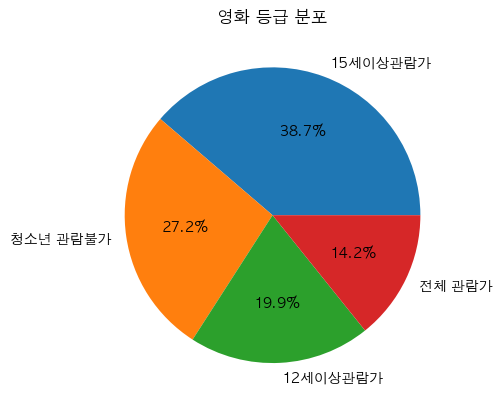

In [34]:
grade_values = movie['grade'].value_counts()
plt.pie(grade_values.values, labels=grade_values.index, autopct='%1.1f%%')
plt.title('영화 등급 분포')
plt.rc('font', family='AppleGothic')

In [35]:
grade_values

grade
15세이상관람가    8980
청소년 관람불가    6307
12세이상관람가    4605
전체 관람가      3302
Name: count, dtype: int64

In [36]:
movie_all = movie[movie['grade'] == '전체 관람가']['story']
movie_12 = movie[movie['grade'] == '12세이상관람가']['story']

In [37]:
# # 데이터 증강
# movie_all_translate = []

# for index, text in enumerate(movie_all[2371:]):
#     english = GoogleTranslator(source='ko', target='en').translate(text)
#     if index % 1 == 0:
#         print(index)
#         print(english)
#     korean = GoogleTranslator(source='en', target='ko').translate(english)
#     if index % 1 == 0:
#         print(korean)
#     movie_all_translate.append(korean)

In [38]:
# pd.DataFrame({'story' : movie_all_translate,
#               'grade' : ['전체 관람가'] * len(movie_all_translate)}).to_csv('movie_all.csv', index=False)

In [39]:
movie_12

12       초고속 네트워크 사회, 점점 더 지능화되고 흉포화 해지는 범죄에 대항하기 위해 정부...
27       40대의 명망 있는 작가 이준섭은 5년이 넘게 치매를 앓아온 시골의 노모가 돌아가셨...
48       오 마이 갓! 바뀌었다! 바닥을 헤매는 성적에 맞는 데는 이력이 난 말썽꾸러기 강대...
57       수녀복을 벗고 유명가수가 된 들로리스에게 수녀들이 간곡히 도와달라고 한다. 이에 다...
62       헨리 빅스는 가난한 동네 교회의 목사이며, 그의 아내 줄리아는 성가대 리더이다. 줄...
                               ...                        
23181    크리스마스 D-1, 철통같은 보안을 뚫고 코드명 '레드 원' 산타클로스가 납치되고 ...
23184    2022년 9월 가장 뜨거웠던 그날의 기억모두의 가슴을 울릴 재난 휴먼 드라마! 전...
23187    [입주민 여러분께 협조 요청 드립니다] 북촌아파트 경비실입니다. 최근 우리 단지 내...
23188    AI와 대우주 시대, 그 사이에서 충돌하는 인류! AI의 발전은 인류의 축복인가 대...
23189    “아프고 슬프고 괴롭지만그래도 사람들은 사랑에 빠진다” 결혼을 앞둔 4월의 어느 날...
Name: story, Length: 4605, dtype: object

In [40]:
# # 데이터 증강
# movie_12_translate = []

# for index, text in enumerate(movie_12[1000:]):
#     english = GoogleTranslator(source='ko', target='en').translate(text)
#     if index % 30 == 0:
#         print(english)
#     korean = GoogleTranslator(source='en', target='ko').translate(english)
#     if index % 30 == 0:
#         print(korean)
#     movie_12_translate.append(korean)

In [41]:
# all_df = pd.DataFrame({'story' : movie_12_translate,
#               'grade' : ['12세이상관람가'] * len(movie_12_translate)})
# pd.concat([pd.read_csv('movie_12.csv'), all_df]).to_csv('movie_12.csv', index=False)

In [50]:
total_movie = pd.concat([movie[['story', 'grade']], pd.read_csv('movie_all.csv'), pd.read_csv('movie_12.csv')])
total_movie

,story,grade
0,LA 경찰국 강력계의 빈센트 한나(알 파치노) 반장은 두 번의 이혼 경력과 순탄치 ...,청소년 관람불가
1,미국 4대 항공사인 엔디버 항공사의 사장이자 재력가인 톰 멀론은 성공의 상징이며 언...,15세이상관람가
2,에드워드는 망해가는 회사를 사들여 나누어서 비싸게 파는 일을 하는 부유하고도 냉정한...,청소년 관람불가
3,사랑이 짧으면 슬픔은 길어진다! 벤은 할리우드에서 유망한 극작가이다. 그의 작품은 ...,청소년 관람불가
4,“절대 그녀에게서 눈을 떼지 말 것” “절대 경호를 풀지 말 것” “절대 사랑에 빠...,15세이상관람가
...,...,...
1125,심슨 가족의 진짜 코믹한 진짜 색깔! <심슨 가족 무비>는 바로 이런 내용입니다!!...,12세이상관람가
1126,"1953년 초여름, 정전이 임박했을 무렵 전선에서는 파벌 간의 치열한 전투가 벌어지...",12세이상관람가
1127,"온 세상이 눈으로 뒤덮인 홋카이도의 추운 겨울, 성공을 위해 어머니와 형을 두고 도...",12세이상관람가
1128,파리를 놀라게 할 특별한 로맨스가 시작된다! So Hot! 200년 만에 가장 뜨거...,12세이상관람가


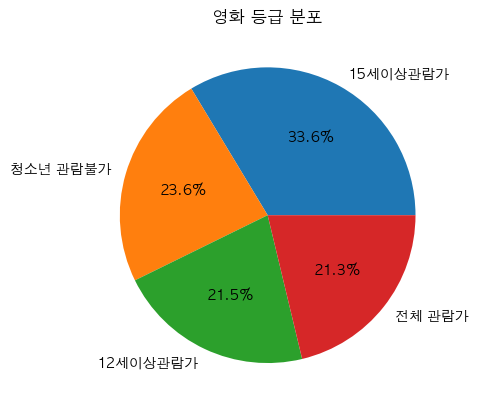

In [51]:
grade_values = total_movie['grade'].value_counts()
plt.pie(grade_values.values, labels=grade_values.index, autopct='%1.1f%%')
plt.title('영화 등급 분포')
plt.rc('font', family='AppleGothic')

In [52]:
total_movie['grade'].value_counts()

grade
15세이상관람가    8980
청소년 관람불가    6307
12세이상관람가    5735
전체 관람가      5673
Name: count, dtype: int64

In [53]:
story = total_movie['story']
grade = total_movie['grade']

In [54]:
with open('movie_stopword.txt', 'r', encoding='utf-8') as f:
    stopwords = [i.strip() for i in f.readlines()]

total_clean_text = []
for text in story:
    token = Okt().morphs(text)
    clean_token = remove_punctuation(token)
    clean_token = remove_stopwords(clean_token, stopwords)
    total_clean_text.append(' '.join(clean_token))

In [56]:
df = pd.DataFrame({
    'clean_text' : total_clean_text,
    'label' : grade
})

grade_dict = {'전체 관람가' : 0, '12세이상관람가' : 0, '15세이상관람가' : 1, '청소년 관람불가' : 1}
final_df = df.apply(lambda x : x.replace(grade_dict))
final_df

,clean_text,label
0,LA 경찰 강력 빈센트 한나 알 파치노 반장 두 번의 이혼 경력 순탄 치 않은 세 ...,1
1,미국 대 항공사 인 엔디버 항공사 사장 이자 재력 가인 톰 멀 론 성공 상징 이며 ...,1
2,에드워드 망해가는 회사 사들여 나누어서 비싸게 파는 하는 부유 하고도 냉정한 사업가...,1
3,사랑 짧으면 슬픔 길어진다 벤은 할리우드 유망 극작가 작품 좋은 평판 받고 있지만 ...,1
4,절대 그녀 눈 떼지 말 절대 경호 풀 지 말 절대 사랑 빠지지 말 전직 대통령 경호...,1
...,...,...
1125,심슨 가족 진짜 코믹 진짜 색깔 심슨 가족 무비 내용 입니다 평화로운 마을 스프링필...,0
1126,초여름 정전 임박 했을 전선 에서는 파벌 치열한 전투 벌어지고 있었습니다 쯤 전투 ...,0
1127,온 세상 눈 뒤 덮인 홋카이도 추운 겨울 성공 어머니 형 두고 도쿄 떠난 마나 부는...,0
1128,파리 놀라게 할 특별한 로맨스 시작 So Hot 만에 가장 뜨거운 스캔들 터졌다 날...,0


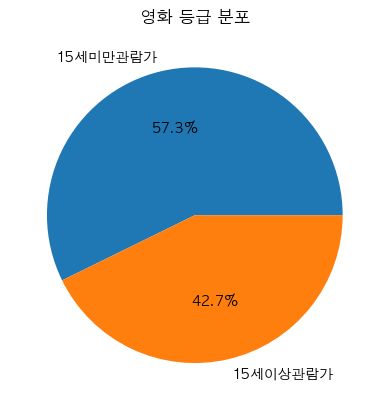

In [59]:
grade_values = final_df['label'].value_counts()
plt.pie(grade_values.values, labels=['15세미만관람가', '15세이상관람가'], autopct='%1.1f%%')
plt.title('영화 등급 분포')
plt.rc('font', family='AppleGothic')

In [159]:
# final_df1 = final_df[final_df['label'] == 1].iloc[:7000,:]
# final_df0 = final_df[final_df['label'] == 0]

# final_df = pd.concat([final_df0, final_df1])
# final_df['label'].value_counts()

In [160]:
# final_df0 = final_df[final_df['label'] == 0]
# final_df1 = final_df[final_df['label'] == 1]
# final_df2 = final_df[final_df['label'] == 2]
# final_df3 = final_df[final_df['label'] == 3]

# final_df = pd.concat([final_df0, final_df1, final_df2.iloc[:5000,:], final_df3])
# final_df

In [60]:
# 훈련, 검증, 테스트 데이터 분리
# featureDF = final_df[['clean_text']]
# targetDF = final_df[['label']]

featureDF = final_df[['clean_text']]
targetDF = final_df[['label']]

train_inputDF, test_inputDF, train_targetDF, test_targetDF = train_test_split(featureDF, targetDF,
                                                                      stratify = targetDF,
                                                                      train_size = 0.8, random_state = 42)
train_inputDF, valid_inputDF, train_targetDF, valid_targetDF = train_test_split(train_inputDF, train_targetDF,
                                                                        stratify = train_targetDF,
                                                                        train_size = 0.8, random_state = 42)
print(f"[train] input : {train_inputDF.shape}, target : {train_targetDF.shape}")
print(f"[valid] input : {valid_inputDF.shape}, target : {valid_targetDF.shape}")
print(f"[test] input : {test_inputDF.shape}, target : {test_targetDF.shape}")

[train] input : (17084, 1), target : (17084, 1)
[valid] input : (4272, 1), target : (4272, 1)
[test] input : (5339, 1), target : (5339, 1)


In [61]:
max_features = 20000
vectorizer = TfidfVectorizer(max_features=max_features)
train_vector = vectorizer.fit_transform(train_inputDF['clean_text']).toarray()
valid_vector = vectorizer.transform(valid_inputDF['clean_text']).toarray()
test_vector = vectorizer.transform(test_inputDF['clean_text']).toarray()

joblib.dump(vectorizer, f'tfidfvectorizer_{max_features}.pkl')

['tfidfvectorizer_20000.pkl']

In [62]:
train_vectorDF = pd.DataFrame(train_vector)
valid_vectorDF = pd.DataFrame(valid_vector)
test_vectorDF = pd.DataFrame(test_vector)
train_vectorDF

,0,1,2,3,4,5,6,7,8,9,...,19990,19991,19992,19993,19994,19995,19996,19997,19998,19999
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17079,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17080,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17081,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17082,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
trainDS = CustomDataset(train_vectorDF, train_targetDF, feature_dim=2)
validDS = CustomDataset(valid_vectorDF, valid_targetDF, feature_dim=2)
testDS = CustomDataset(test_vectorDF, test_targetDF, feature_dim=2)

trainDL = DataLoader(trainDS, batch_size=128)
validDL = DataLoader(validDS, batch_size=128)
testDL = DataLoader(testDS, batch_size=128)

In [64]:
for X_batch, y_batch in trainDL:
    print(X_batch.shape)  # X_batch의 차원 출력
    break  # 첫 번째 배치만 확인하기 위해 루프를 중지

torch.Size([128, 1, 20000])


In [65]:
class TextModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_list, act_func, model, num_layers=1):
        super().__init__()
        # 입력층 (LSTM)
        if model == 'lstm':
            self.lstm_layer = nn.LSTM(input_size, hidden_list[0], num_layers, batch_first=True)
        elif model == 'rnn':
            self.rnn_layer = nn.RNN(input_size, hidden_list[0], num_layers, batch_first=True)
        elif model == 'gru':
            self.gru_layer = nn.GRU(input_size, hidden_list[0], num_layers, batch_first=True)
        # 은닉층
        self.hidden_layer_list = nn.ModuleList()
        for i in range(len(hidden_list)-1):
            self.hidden_layer_list.append(nn.Linear(hidden_list[i], hidden_list[i+1]))
        # 출력층
        self.output_layer = nn.Linear(hidden_list[-1], output_size)

        self.act_func = act_func
        self.dropout = nn.Dropout(0.5)
        self.model = model
        
    def forward(self, x):
        # 입력층
        if self.model == 'lstm':
            lstm_out, (hn, cn) = self.lstm_layer(x) # lstm_out : 모든 타입스텝 출력
            x = lstm_out[:, -1, :] # 마지막 타입스텝 출력
        elif self.model == 'rnn':
            rnn_out, hn = self.rnn_layer(x) # rnn_out : 모든 타입스텝 출력
            x = rnn_out[:, -1, :] # 마지막 타입스텝 출력
        elif self.model == 'gru':
            gru_out, hn = self.gru_layer(x) # gru_out : 모든 타입스텝 출력
            x = gru_out[:, -1, :] # 마지막 타입스텝 출력
        # 은닉층
        for layer in self.hidden_layer_list:
            x = layer(x)
            x = self.act_func(x)
            x = self.dropout(x)
        # 출력층
        return self.output_layer(x) # 로짓값

In [66]:
# import torch
# import torch.nn as nn

# class LSTMModel(nn.Module):
#     def __init__(self, input_size, output_size, hidden_list, act_func, model_type, num_layers=1, dropout_rate=0.5):
#         super().__init__()
        
#         # LSTM 레이어
#         self.lstm = nn.LSTM(input_size, hidden_list[0], num_layers=num_layers, batch_first=True, dropout=dropout_rate)
        
#         # 은닉층
#         self.hidden_layer_list = nn.ModuleList()
#         for i in range(len(hidden_list)-1):
#             self.hidden_layer_list.append(nn.Linear(hidden_list[i], hidden_list[i+1]))
#             # 배치 정규화 추가
#             self.hidden_layer_list.append(nn.BatchNorm1d(hidden_list[i+1]))

#         # 출력층
#         self.output_layer = nn.Linear(hidden_list[-1], output_size)

#         self.act_func = act_func
#         self.model_type = model_type
#         self.dropout = nn.Dropout(dropout_rate)  # 드롭아웃 레이어 추가

#     def forward(self, x):
#         # LSTM 레이어를 통과
#         lstm_out, (hn, cn) = self.lstm(x)

#         # 마지막 타임스텝의 출력을 사용
#         x = lstm_out[:, -1, :]

#         # 은닉층
#         for layer in self.hidden_layer_list:
#             x = layer(x)
#             x = self.act_func(x)
#             x = self.dropout(x)  # 드롭아웃 적용

#         # 출력층
#         if self.model_type == 'regression':  # 회귀
#             return self.output_layer(x)
#         elif self.model_type == 'binary':  # 이진 분류
#             return torch.sigmoid(self.output_layer(x))
#         elif self.model_type == 'multiclass':  # 다중 분류
#             return self.output_layer(x)  # CrossEntropyLoss에서 log-softmax 처리
#         elif self.model_type == 'multilabel':  # 다중 레이블
#             return torch.sigmoid(self.output_layer(x))

In [67]:
from collections import Counter
Counter(train_targetDF['label'])

Counter({0: 7300, 1: 9784})

In [68]:
# from collections import Counter
# import torch

# # 각 클래스의 샘플 수 계산
# class_counts = Counter(train_targetDF['label'])  # train_labels는 각 샘플의 레이블 리스트
# total_samples = sum(class_counts.values())

# # 클래스 레이블을 정렬 (예: [0, 1, 2, 3] 등)
# sorted_classes = sorted(class_counts.keys())

# # 클래스별 가중치 계산 (샘플 수에 반비례)
# class_weights = {cls: total_samples / class_counts[cls] for cls in sorted_classes}

# # 텐서로 변환 (정렬된 순서로 가중치 적용)
# weights = torch.tensor([class_weights[cls] for cls in sorted_classes], dtype=torch.float32)
# weights


In [69]:
# def testing(test_DataLoader, model, model_type, num_classes=None,
#             MPS = None, device = None):
#     model.eval() # 검증 모드임을 명시적으로 선언 (검증용 통계치 사용 및 드롭아웃 비활성화)
#     total_loss_test = 0
#     total_score_test = 0

#     with torch.no_grad(): # 가중치 업데이트 없이 테스트 진행
#         for X_batch, y_batch in test_DataLoader:
#             if MPS == True:
#                 model.to(device)  # 모델을 MPS 장치로 이동
                
#                 X_batch = X_batch.to(device).float()
#                 y_batch = y_batch.to(device)

#             # (1) 순전파 (평가)
#             pred_test_y = model(X_batch)
#             # (2) 손실 함수 계산

#             if model_type == 'regression': # 회귀일 때
#                 loss_test = F.mse_loss(pred_test_y, y_batch)
#                 score_test = r2_score(pred_test_y, y_batch)

#             elif model_type == 'binary': # 이진 분류일 때
#                 pred_test_y = torch.sigmoid(pred_test_y) # 확률값 출력
#                 loss_test = F.binary_cross_entropy(pred_test_y, y_batch) # 확률값을 전달해야 함
#                 pred_test_y = pred_test_y.round() # 확률값을 0또는 1로 변환
#                 score_test = f1_score(pred_test_y, y_batch, task='binary') # 0또는 1로 변환된 값을 전달

#             elif model_type == 'multiclass': # 다중 분류일 때
#                 y_batch1D = y_batch.reshape(-1) # 다중 분류는 y가 반드시 1차원이어야 함.. (너무 불친절)
#                 loss_test = F.cross_entropy(pred_test_y, y_batch1D.long(), weight=weights.to(device)) 
#                 pred_test_labels = torch.argmax(pred_test_y, dim=1)
#                 # dim=1을 해야 한 행 내에서 가장 큰 원소의 인덱스를 가져옴
#                 score_test = f1_score(pred_test_labels, y_batch1D,
#                                       task='multiclass', num_classes=num_classes)
#                 # 다중 분류는 long타입으로 전달해야 하는듯

#             elif model_type == 'multilabel': # 다중 레이블일 때
#                 pred_test_y = torch.sigmoid(pred_test_y) # OvR 확률값 출력
#                 loss_test = F.binary_cross_entropy(pred_test_y, y_batch) # 확률값을 전달해야 함
#                 pred_test_y = (pred_test_y > 0.5).float() # 각 컬럼 마다 0 또는 1의 예측값 출력
#                 score_test = f1_score(pred_test_y, y_batch, num_labels=num_classes,
#                                        average='micro', task='multilabel') # 다중 레이블은 micro가 적합

#             total_loss_test += loss_test.item()
#             total_score_test += score_test.item()

#     loss_test_avg = total_loss_test / len(test_DataLoader)
#     score_test_avg = total_score_test / len(test_DataLoader)
#     return loss_test_avg, score_test_avg

# # -----------------------------------------------------------------
# # 모델 학습 함수
# # -----------------------------------------------------------------
# def training(train_DataLoader, test_DataLoader, model, model_type, optimizer,
#              epoch = 1000, endurance_cnt = 10, view_epoch=1, num_classes=None, SAVE_PATH=None,
#              MPS = None, device = None):
#     model.train() # 학습 모드임을 명시적으로 선언 (학습용 통계치 사용)
#     loss_train_history = []
#     loss_test_history = []
#     score_train_history = []
#     score_test_history = []

#     EARLY_STOP_LOSS_CNT = 0

#     for i in range(1, epoch+1): # 에포크 횟수만큼 반복
#         total_loss_train = 0 # 한 에포크당 합산할 손실값 (나중에 평균 계산)
#         total_score_train = 0 # 한 에포크당 합산할 손실값 (나중에 평균 계산)

#         for X_batch, y_batch in train_DataLoader:
#             if MPS:
#                 model.to(device)  # 모델을 MPS 장치로 이동
#                 optimizer = optimizer # 디바이스가 설정된 바로 뒤에 optimizer를 위치

#                 X_batch = X_batch.to(device).float()
#                 y_batch = y_batch.to(device)
            
#             # (1) 순전파 (학습)
#             pred_train_y = model(X_batch)
#             # (2) 손실 함수 계산
#             if model_type == 'regression': # 회귀일 때
#                 loss_train = F.mse_loss(pred_train_y, y_batch)
#                 score_train = r2_score(pred_train_y, y_batch)

#             elif model_type == 'binary': # 이진 분류일 때
#                 pred_train_y = torch.sigmoid(pred_train_y) # 확률값 출력
#                 loss_train = F.binary_cross_entropy(pred_train_y, y_batch) # 확률값을 전달해야 함
#                 pred_train_y = pred_train_y.round() # 확률값을 0또는 1로 변환
#                 score_train = f1_score(pred_train_y, y_batch, task='binary') # 0또는 1로 변환된 값을 전달

#             elif model_type == 'multiclass': # 다중 분류일 때
#                 y_batch1D = y_batch.reshape(-1) # 다중 분류는 y가 반드시 1차원이어야 함.. (너무 불친절)
#                 loss_train = F.cross_entropy(pred_train_y, y_batch1D.long(), weight=weights.to(device))
#                 pred_train_labels = torch.argmax(pred_train_y, dim=1)
#                 # dim=1을 해야 한 행 내에서 가장 큰 원소의 인덱스를 가져옴
#                 score_train = f1_score(pred_train_labels, y_batch1D,
#                                        task='multiclass', num_classes=num_classes)
#                 # 다중 분류는 long타입으로 전달해야 하는듯

#             elif model_type == 'multilabel': # 다중 레이블일 때
#                 pred_train_y = torch.sigmoid(pred_train_y) # OvR 확률값 출력
#                 loss_train = F.binary_cross_entropy(pred_train_y, y_batch) # 확률값을 전달해야 함
#                 pred_train_y = (pred_train_y > 0.5).float() # 각 컬럼 마다 0 또는 1의 예측값 출력
#                 score_train = f1_score(pred_train_y, y_batch, num_labels=num_classes,
#                                        average='micro', task='multilabel') # 다중 레이블은 micro가 적합

#             # (3) 최적화
#             optimizer.zero_grad() # 그레디언트 초기화
#             loss_train.backward() # 역전파 하면서 그레디언트 계산
#             optimizer.step() # 가중치, 절편 업데이트
#             # (4) 손실값 합산
#             total_loss_train += loss_train.item()
#             total_score_train += score_train.item()

#         loss_train_avg = total_loss_train / len(train_DataLoader)
#         score_train_avg = total_score_train / len(train_DataLoader)
        
#         # 한 에포크마다 테스트 실행
#         if model_type == 'regression':
#             loss_test_avg, score_test_avg = testing(test_DataLoader, model, model_type='regression',
#                                                     MPS =  MPS, device = device)
#         elif model_type == 'binary':
#             loss_test_avg, score_test_avg = testing(test_DataLoader, model, model_type='binary',
#                                                     MPS = MPS, device = device)
#         elif model_type == 'multiclass':
#             loss_test_avg, score_test_avg = testing(test_DataLoader, model, model_type='multiclass',
#                                                     num_classes=num_classes, MPS = MPS, device = device)
#         elif model_type == 'multilabel':
#             loss_test_avg, score_test_avg = testing(test_DataLoader, model, model_type='multilabel',
#                                                     MPS = MPS, num_classes=num_classes, device = device)

#         loss_train_history.append(loss_train_avg)
#         loss_test_history.append(loss_test_avg)
#         score_train_history.append(score_train_avg)
#         score_test_history.append(score_test_avg)

#         if len(loss_test_history) == 1: # 첫 에포크일때
#             best_loss = loss_test_avg
#             if SAVE_PATH != None:
#                 torch.save({
#                     'model_state_dict' : model.state_dict(),
#                      'optimizer_state_dict' : optimizer.state_dict(),
#                       }, f'{SAVE_PATH}/best_model_epoch_{i}.pth')
#             print(f"[EPOCH] : {i}에서 모델 저장 완료.")

#         else:
#             if best_loss > loss_test_avg: # 손실값이 개선 됐다면
#                 best_loss = loss_test_avg
#                 EARLY_STOP_LOSS_CNT = 0 # 개선되면 카운트 초기화
#                 if SAVE_PATH != None:
#                     torch.save({
#                         'model_state_dict' : model.state_dict(),
#                          'optimizer_state_dict' : optimizer.state_dict(),
#                           }, f'{SAVE_PATH}/best_model_epoch_{i}.pth')
#                 print(f"[EPOCH] : {i}에서 모델 저장 완료.")
#             else:                         # 손실값이 개선되지 않았다면
#                 EARLY_STOP_LOSS_CNT += 1

#         if EARLY_STOP_LOSS_CNT == endurance_cnt:
#             print(f'[Loss]값의 개선이 이루어지지 않아 [{i}] EPOCH에서 학습을 종료합니다.')
#             break

#         # (4) 학습 결과 출력
#         if i % view_epoch == 0:
#             print(f"[Loss : {i}/{epoch}] Train : {loss_train_avg:.4f}, Test : {loss_test_avg:.4f}")
#             print(f"[Score  : {i}/{epoch}] Train : {score_train_avg:.4f}, Test : {score_test_avg:.4f}")

#         # 여기서 GPU 캐시를 정리
#         if MPS:
#             torch.cuda.empty_cache()
    
#     return loss_train_history, loss_test_history, score_train_history, score_test_history

In [ ]:
from KDTModule import *

model = TextModel(input_size = 20000, output_size = 1, hidden_list = [100],
                  act_func=F.relu, model='lstm', num_layers=2)
# num_layers : 재귀층(Recurrent Layer)의 개수 (기본적인 LSTM 모델에서는 1개)

adam_optim = optim.Adam(model.parameters(), lr = 0.0005)

# 모델 훈련
EPOCH = 200
SAVE_PATH = '/Users/anhyojun/WorkSpace/LocalData/9번째 프로젝트/lstm'
result = training(trainDL, validDL, model, 'binary', adam_optim, EPOCH,
                  endurance_cnt=10, num_classes=1, SAVE_PATH=SAVE_PATH)

In [194]:
from KDTModule import *

model = TextModel(input_size = 20000, output_size = 1, hidden_list = [100],
                  act_func=F.relu, model='rnn', num_layers=2)
# num_layers : 재귀층(Recurrent Layer)의 개수 (기본적인 LSTM 모델에서는 1개)

adam_optim = optim.Adam(model.parameters(), lr = 0.0005)

# 모델 훈련
EPOCH = 200
SAVE_PATH = '/Users/anhyojun/WorkSpace/LocalData/9번째 프로젝트/rnn'
result = training(trainDL, validDL, model, 'binary', adam_optim, EPOCH,
                  endurance_cnt=10, num_classes=1, SAVE_PATH=SAVE_PATH)

[EPOCH] : 1에서 모델 저장 완료.
[Loss : 1/200] Train : 0.5980, Test : 0.4560
[Score  : 1/200] Train : 0.7692, Test : 0.8202
[Loss : 2/200] Train : 0.3372, Test : 0.4619
[Score  : 2/200] Train : 0.8737, Test : 0.8157
[Loss : 3/200] Train : 0.1986, Test : 0.5751
[Score  : 3/200] Train : 0.9358, Test : 0.8069
[Loss : 4/200] Train : 0.1029, Test : 0.7617
[Score  : 4/200] Train : 0.9726, Test : 0.7994
[Loss : 5/200] Train : 0.0394, Test : 0.9781
[Score  : 5/200] Train : 0.9934, Test : 0.8061
[Loss : 6/200] Train : 0.0142, Test : 1.1995
[Score  : 6/200] Train : 0.9994, Test : 0.8064
[Loss : 7/200] Train : 0.0090, Test : 1.4057
[Score  : 7/200] Train : 0.9998, Test : 0.7768
[Loss : 8/200] Train : 0.0059, Test : 1.6483
[Score  : 8/200] Train : 0.9999, Test : 0.7967


KeyboardInterrupt: 

In [70]:
from KDTModule import *

model = TextModel(input_size = 20000, output_size = 1, hidden_list = [100],
                  act_func=F.relu, model='gru', num_layers=2)
# num_layers : 재귀층(Recurrent Layer)의 개수 (기본적인 LSTM 모델에서는 1개)

adam_optim = optim.Adam(model.parameters(), lr = 0.0005)

# 모델 훈련
EPOCH = 200
SAVE_PATH = '/Users/anhyojun/WorkSpace/LocalData/9번째 프로젝트/gru'
result = training(trainDL, validDL, model, 'binary', adam_optim, EPOCH,
                  endurance_cnt=10, num_classes=1, SAVE_PATH=SAVE_PATH)

[EPOCH] : 1에서 모델 저장 완료.
[Loss : 1/200] Train : 0.6398, Test : 0.5096
[Score  : 1/200] Train : 0.7040, Test : 0.8212
[EPOCH] : 2에서 모델 저장 완료.
[Loss : 2/200] Train : 0.3765, Test : 0.4423
[Score  : 2/200] Train : 0.8606, Test : 0.8220
[Loss : 3/200] Train : 0.2240, Test : 0.5292
[Score  : 3/200] Train : 0.9254, Test : 0.8127
[Loss : 4/200] Train : 0.1230, Test : 0.7007
[Score  : 4/200] Train : 0.9633, Test : 0.8117
[Loss : 5/200] Train : 0.0525, Test : 0.9167
[Score  : 5/200] Train : 0.9895, Test : 0.8104


KeyboardInterrupt: 

In [72]:
class TextModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_list, act_func, model, num_layers=1):
        super().__init__()
        # 입력층 (LSTM)
        if model == 'lstm':
            self.lstm_layer = nn.LSTM(input_size, hidden_list[0], num_layers, batch_first=True)
        elif model == 'rnn':
            self.rnn_layer = nn.RNN(input_size, hidden_list[0], num_layers, batch_first=True)
        elif model == 'gru':
            self.gru_layer = nn.GRU(input_size, hidden_list[0], num_layers, batch_first=True)
        # 은닉층
        self.hidden_layer_list = nn.ModuleList()
        for i in range(len(hidden_list)-1):
            self.hidden_layer_list.append(nn.Linear(hidden_list[i], hidden_list[i+1]))
        # 출력층
        self.output_layer = nn.Linear(hidden_list[-1], output_size)

        self.act_func = act_func
        self.dropout = nn.Dropout(0.5)
        self.model = model
        
    def forward(self, x):
        # 입력층
        if self.model == 'lstm':
            lstm_out, (hn, cn) = self.lstm_layer(x) # lstm_out : 모든 타입스텝 출력
            x = lstm_out[:, -1, :] # 마지막 타입스텝 출력
        elif self.model == 'rnn':
            rnn_out, hn = self.rnn_layer(x) # rnn_out : 모든 타입스텝 출력
            x = rnn_out[:, -1, :] # 마지막 타입스텝 출력
        elif self.model == 'gru':
            gru_out, hn = self.gru_layer(x) # gru_out : 모든 타입스텝 출력
            x = gru_out[:, -1, :] # 마지막 타입스텝 출력
        # 은닉층
        for layer in self.hidden_layer_list:
            x = layer(x)
            x = self.act_func(x)
            x = self.dropout(x)
        # 출력층
        return self.output_layer(x) # 로짓값

with open('movie_stopword.txt', 'r', encoding='utf-8') as f:
    stopwords = [i.strip() for i in f.readlines()]



token = Okt().morphs(sentence)
clean_token = remove_punctuation(token)
clean_token = remove_stopwords(clean_token, stopwords)
clean_text = ' '.join(clean_token)
textDF = pd.DataFrame({'clean_text' : [clean_text]})

loaded_vectorizer = joblib.load('tfidfvectorizer.pkl')
text_vector = loaded_vectorizer.transform(textDF['clean_text']).toarray()
text_vectorDF = pd.DataFrame(text_vector)




best_model = TextModel(input_size = 20000, output_size = 1, hidden_list = [100],
                       act_func=F.relu, model='lstm', num_layers=2)
best_model.eval()
checkpoint = torch.load('movie_model.pth')
best_model.load_state_dict(checkpoint['model_state_dict'])

tensor = torch.tensor(text_vectorDF.values, dtype=torch.float)
# 출력층에서 로짓 값을 반환하므로, sigmoid로 확률을 압축
predicted_value = torch.sigmoid(best_model(tensor.unsqueeze(1)))
predicted_value = (predicted_value > 0.5).float().item()  # 0.5를 기준으로 0 또는 1로 변환

if predicted_value == 0:
    predicted_value = '15세미만관람가'
elif predicted_value == 1:
    predicted_value = '15세이상관람가'

predicted_value

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [103]:


best_model = TextModel(input_size = 20000, output_size = 1, hidden_list = [100],
                       act_func=F.relu, model='lstm', num_layers=2)
best_model.eval()
checkpoint = torch.load('movie_model.pth')
best_model.load_state_dict(checkpoint['model_state_dict'])

tensor = torch.tensor(test_vectorDF.values, dtype=torch.float)
# 출력층에서 로짓 값을 반환하므로, sigmoid로 확률을 압축
predicted_value = torch.sigmoid(best_model(tensor.unsqueeze(1)))
predicted_value = (predicted_value > 0.5).float()  # 0.5를 기준으로 0 또는 1로 변환

In [110]:
predicted_value, test_targetDF['label'].values

(tensor([[1.],
         [0.],
         [0.],
         ...,
         [0.],
         [0.],
         [1.]]),
 array([1, 0, 1, ..., 0, 0, 1]))

In [117]:
from sklearn.metrics import classification_report
import numpy as np

# predicted_value를 numpy 배열로 변환
predicted_value_np = predicted_value.numpy().flatten()  # 1D 배열로 변환
actual_labels = test_targetDF['label'].values

# classification_report 출력
report = classification_report(actual_labels, predicted_value_np)
print(f"-------------------테스트 성능 지표------------------")
print(report)

-------------------테스트 성능 지표------------------
              precision    recall  f1-score   support

           0       0.78      0.74      0.76      2282
           1       0.82      0.84      0.83      3057

    accuracy                           0.80      5339
   macro avg       0.80      0.79      0.79      5339
weighted avg       0.80      0.80      0.80      5339



In [108]:
accuracy_list = []
for i, j in zip(predicted_value.squeeze(), test_targetDF['label'].values):
    if i.item() == j:
        accuracy_list.append(1)
    else:
        accuracy_list.append(0)

accuracy = sum(accuracy_list)/len(accuracy_list)
print(f"Test Accuracy : {accuracy:.2f}")

Test Accuracy : 0.80
